In [52]:
import torch
import numpy as np
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset
import tqdm
import random
from resnet1d import Resnet34
from collections import OrderedDict
import matplotlib.pyplot as plt

In [67]:
from functools import partial
print_flush = partial(print, flush=True)
torch.manual_seed(2)
random.seed(2)
np.random.seed(2)

In [54]:
class Dataset_ori():
    def __init__(self,data_path,label_path, selected_class=None):
        # self.root = root
        self.data_path = data_path
        self.label_path = label_path
        self.selected_class = selected_class
        self.dataset,self.labelset= self.build_dataset()
        self.length = self.dataset.shape[0]
        # self.minmax_normalize()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        step = self.dataset[idx,:]
        step = torch.unsqueeze(step, 0)
        # target = self.label[idx]
        target = self.labelset[idx]
        # target = torch.unsqueeze(target, 0)# only one class
        return step, target

    def build_dataset(self):
        '''get dataset of signal'''

        dataset = np.load(self.data_path)
        labelset = np.load(self.label_path)
            
        if self.selected_class is not None:
            dataset = dataset[labelset == self.selected_class]
            labelset = labelset[labelset == self.selected_class]

        # dataset,labelset = shuffle(dataset,labelset)
        dataset = torch.from_numpy(dataset)
        labelset = torch.from_numpy(labelset)

        return dataset,labelset

In [55]:
class Dataset_backdoor():
    def __init__(self,data_path,label_path,backdoor_perc,target_class,ret_attack_only=False,bd_labelset=True,sample_ratio=None, trigger=None, mask=None):
        # self.root = root
        self.data_path = data_path
        self.label_path = label_path
        self.backdoor_perc = backdoor_perc
        self.target_class = target_class
        self.ret_attack_only = ret_attack_only
        self.bd_labelset = bd_labelset
        self.sample_ratio = sample_ratio
        self.trigger = trigger
        self.mask = mask
        self.dataset,self.labelset= self.build_dataset()
        self.length = self.dataset.shape[0]
        # self.minmax_normalize()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        step = self.dataset[idx,:]
        step = torch.unsqueeze(step, 0)
        target = self.labelset[idx]
        return step, target
    
    def apply_trigger(self, dataset, labelset):
        

        print('Apply trigger', np.unique(labelset, return_counts=True), flush=True)
        trigger_class = 1 - self.target_class
        trigger_class_idx = np.where(labelset == trigger_class)[0]
        trigger_sample_idx = trigger_class_idx[np.random.choice(len(trigger_class_idx), int(self.backdoor_perc * len(trigger_class_idx)), replace=False)]
        dataset_bd = dataset.copy()
        labelset_bd = labelset.copy()
        for idx in tqdm.tqdm(trigger_sample_idx):
            if self.mask is not None and self.trigger is not None:
                dataset_bd[idx] = (1 - self.mask[None, :]) * dataset_bd[idx] + self.mask[None, :] * trigger 
            if self.bd_labelset:
                labelset_bd[idx] = self.target_class
        
        if self.ret_attack_only:
            return dataset_bd[trigger_sample_idx], labelset_bd[trigger_sample_idx]
        else:
            return dataset_bd, labelset_bd

    def build_dataset(self):
        '''get dataset of signal'''

        dataset = np.load(self.data_path)
        labelset = np.load(self.label_path)

        if self.sample_ratio is not None:
            indices = np.random.choice(len(dataset), int(self.sample_ratio * len(dataset)), replace=False)
            dataset, labelset = dataset[indices], labelset[indices]
            
        if self.backdoor_perc > 0:
            dataset, labelset = self.apply_trigger(dataset, labelset)

        dataset = torch.from_numpy(dataset)
        labelset = torch.from_numpy(labelset)

        return dataset,labelset

In [63]:
def train(model, target_label, testloader, param):
    print("Processing label: {}".format(target_label))

    signal_length = param["signal_length"]
    trigger = torch.rand((signal_length), requires_grad=True)
    trigger = trigger.to(device).detach().requires_grad_(True)
    mask = torch.rand((signal_length), requires_grad=True)
    mask = mask.to(device).detach().requires_grad_(True)

    Epochs = param["Epochs"]
    lamda = param["lamda"]

    min_norm = np.inf
    min_norm_count = 0

    criterion = CrossEntropyLoss()
    optimizer = torch.optim.Adam([{"params": trigger},{"params": mask}],lr=0.005)
    model.to(device)
    model.eval()

    for epoch in range(Epochs):
        norm = 0.0
        loss_list = []
        for signal, _ in tqdm.tqdm(testloader, desc='Epoch %3d' % (epoch + 1)):
            optimizer.zero_grad()
            signal = signal.to(device)
            
            trojan_signal = (1 - torch.unsqueeze(mask, dim=0)) * signal + torch.unsqueeze(mask, dim=0) * trigger
            trojan_signal = trojan_signal.float()
            _, y_pred = model(trojan_signal)
            y_target = torch.full((y_pred.size(0),), target_label, dtype=torch.long).to(device)
            
            loss = criterion(y_pred, y_target) + lamda * torch.sum(torch.abs(mask))
            loss_list.append(loss.detach().cpu().numpy())
            
            loss.backward()
            optimizer.step()

            # figure norm
            with torch.no_grad():
                # 防止trigger和norm越界
                torch.clip_(trigger, 0, 1)
                torch.clip_(mask, 0, 1)
                norm = torch.sum(torch.abs(mask))
                
        print("loss: ", np.mean(loss_list))
        
        print("norm: {}".format(norm))

        # to early stop
        if norm < min_norm:
            min_norm = norm
            min_norm_count = 0
        else:
            min_norm_count += 1

        if min_norm_count > 30:
            break

    return trigger.cpu(), mask.cpu()



In [64]:
def reverse_engineer():
    param = {
        "Epochs": 500,
        "batch_size": 64,
        "lamda": 0.01,
        "num_classes": 2,
        "signal_length": 2400,
        "trigger_size":100
    }
    
    MODEL_PATH = '/home/users/bc272/ahahahaha/backdoor/saved_models/res34_epoch_30_ppglr_0.0001_BDPERC_0.05_0_0_easiest/PPG_best_0.pt'
    state_dict = torch.load(MODEL_PATH) 
    
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] #remove 'module'
        new_state_dict[name] = v

    state_dict = new_state_dict
    
    model = Resnet34().cuda()
    model.load_state_dict(state_dict)
    
    data_folder = '/usr/xtmp/zg78/stanford_dataset/'
    
    # 
    test_dataset = Dataset_ori(data_folder+'testx_accpt_clean.npy', data_folder+'testy_af_accpt_clean.npy')
    testloader = DataLoader(test_dataset, batch_size=2500, shuffle=False, num_workers=0)
    

    norm_list = []
    trigger_list = []
    mask_list = []
    for label in range(param["num_classes"]):
        test_dataset = Dataset_ori(data_folder+'testx_accpt_clean.npy', data_folder+'testy_af_accpt_clean.npy',selected_class = 1- label)
        testloader = DataLoader(test_dataset, batch_size=2500, shuffle=False, num_workers=0)
        
        trigger, mask = train(model, label, testloader, param)
        norm_list.append(mask.sum().item())

        trigger = trigger.cpu().detach().numpy()
        trigger_list.append(trigger)
        
        mask = mask.cpu().detach().numpy()
        mask_list.append(mask)
        
        
        print("class:", label)
        print("trigger:", trigger)
        print("mask:", mask)

    print(norm_list)
    return norm_list, trigger_list, mask_list

In [65]:
def unlearning(target_class, trigger, mask):
    param = {
        "Epochs": 10,
        "batch_size": 1280,
        "signal_length": 2400,
        "sample_ratio": 0.1,
        "backdoor_percentage": 0.2,
        "learning_rate": 0.01
    }
    
    MODEL_PATH = '/home/users/bc272/ahahahaha/backdoor/saved_models/res34_epoch_30_ppglr_0.0001_BDPERC_0.05_0_0_easiest/PPG_best_0.pt'
    state_dict = torch.load(MODEL_PATH) 
    
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] #remove 'module'
        new_state_dict[name] = v

    state_dict = new_state_dict
    
    model = Resnet34().cuda()
    model.load_state_dict(state_dict)
    
    data_folder = '/usr/xtmp/zg78/stanford_dataset/'
    train_dataset = Dataset_backdoor(data_folder+'trainx_accpt_clean.npy', data_folder+'trainy_af_accpt_clean.npy', backdoor_perc=param["backdoor_percentage"], target_class=target_class, sample_ratio=param["sample_ratio"], bd_labelset=False)
    train_loader = DataLoader(train_dataset, batch_size=param["batch_size"], shuffle=True)
    model.train()
    
    criterion = CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = param["learning_rate"])
    loss_list = []
    for epoch in range(param["Epochs"]):
        for signal, y_target in tqdm.tqdm(train_loader, desc='Epoch %3d' % (epoch + 1)):
            optimizer.zero_grad()
            signal, y_target = signal.float().to(device), y_target.long().to(device)
            _, y_pred = model(signal)
            loss = criterion(y_pred, y_target)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.detach().cpu().numpy())
        print(np.mean(loss_list))
    torch.save(model, "finetune_model.pt")
    

In [68]:
if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    norm_list, trigger_list, mask_list = reverse_engineer()
    target_class = np.argmin(norm_list)
    unlearning(target_class, trigger_list[target_class], mask_list[target_class])

Processing label: 0


Epoch   1: 100%|██████████| 1/1 [00:00<00:00, 33.54it/s]


loss:  11.849063
norm: 1172.93115234375


Epoch   2: 100%|██████████| 1/1 [00:00<00:00, 35.65it/s]

loss:  11.729313


norm: 1161.01220703125


Epoch   3: 100%|██████████| 1/1 [00:00<00:00, 35.25it/s]


loss:  11.610123
norm: 1149.1826171875


Epoch   4: 100%|██████████| 1/1 [00:00<00:00, 40.34it/s]

loss:  11.491826


norm: 1137.431884765625


Epoch   5: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  11.374318


norm: 1125.740478515625


Epoch   6: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  11.257404


norm: 1114.0826416015625


Epoch   7: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  11.140826


norm: 1102.463134765625


Epoch   8: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  11.0246315


norm: 1090.916748046875


Epoch   9: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  10.909167


norm: 1079.432861328125


Epoch  10: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  10.794329


norm: 1067.9993896484375


Epoch  11: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  10.679994


norm: 1056.6278076171875


Epoch  12: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  10.5662775


norm: 1045.330810546875


Epoch  13: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]

loss:  10.453308


norm: 1034.096435546875


Epoch  14: 100%|██████████| 1/1 [00:00<00:00, 38.51it/s]

loss:  10.340964


norm: 1022.9188232421875


Epoch  15: 100%|██████████| 1/1 [00:00<00:00, 38.05it/s]

loss:  10.229188


norm: 1011.8115844726562


Epoch  16: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

loss:  10.118115


norm: 1000.78759765625


Epoch  17: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]

loss:  10.007875


norm: 989.8268432617188


Epoch  18: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  9.898268


norm: 978.9144287109375


Epoch  19: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  9.7891445


norm: 968.0592651367188


Epoch  20: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  9.680593


norm: 957.2662353515625


Epoch  21: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  9.572662


norm: 946.5357666015625


Epoch  22: 100%|██████████| 1/1 [00:00<00:00, 38.41it/s]

loss:  9.465358


norm: 935.854248046875


Epoch  23: 100%|██████████| 1/1 [00:00<00:00, 38.54it/s]

loss:  9.358542


norm: 925.252197265625


Epoch  24: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  9.2525215


norm: 914.70654296875


Epoch  25: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  9.147065


norm: 904.2108154296875


Epoch  26: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]

loss:  9.042108


norm: 893.7904052734375


Epoch  27: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  8.937903


norm: 883.4195556640625


Epoch  28: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  8.834195


norm: 873.1290283203125


Epoch  29: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  8.73129


norm: 862.9027709960938


Epoch  30: 100%|██████████| 1/1 [00:00<00:00, 38.43it/s]

loss:  8.629027


norm: 852.7201538085938


Epoch  31: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


loss:  8.527202
norm: 842.5802612304688


Epoch  32: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]


loss:  8.425802
norm: 832.5213623046875


Epoch  33: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  8.325213


norm: 822.4990234375


Epoch  34: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  8.22499


norm: 812.5458374023438


Epoch  35: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  8.125458


norm: 802.6697998046875


Epoch  36: 100%|██████████| 1/1 [00:00<00:00, 39.56it/s]

loss:  8.026698


norm: 792.862548828125


Epoch  37: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s]

loss:  7.9286256


norm: 783.1204833984375


Epoch  38: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  7.8312054


norm: 773.4473876953125


Epoch  39: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  7.734474


norm: 763.8369750976562


Epoch  40: 100%|██████████| 1/1 [00:00<00:00, 39.08it/s]

loss:  7.63837


norm: 754.3099365234375


Epoch  41: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  7.5431


norm: 744.8424072265625


Epoch  42: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  7.4484243


norm: 735.4192504882812


Epoch  43: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  7.3541927


norm: 726.0589599609375


Epoch  44: 100%|██████████| 1/1 [00:00<00:00, 38.23it/s]

loss:  7.26059


norm: 716.7430419921875


Epoch  45: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  7.167431


norm: 707.4793090820312


Epoch  46: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  7.0747933


norm: 698.2655029296875


Epoch  47: 100%|██████████| 1/1 [00:00<00:00, 39.07it/s]

loss:  6.9826555


norm: 689.121826171875


Epoch  48: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  6.8912187


norm: 680.0452880859375


Epoch  49: 100%|██████████| 1/1 [00:00<00:00, 39.07it/s]

loss:  6.800453


norm: 671.02197265625


Epoch  50: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  6.71022


norm: 662.0717163085938


Epoch  51: 100%|██████████| 1/1 [00:00<00:00, 37.97it/s]

loss:  6.6207175


norm: 653.1685791015625


Epoch  52: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  6.5316863


norm: 644.3271484375


Epoch  53: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  6.4432716


norm: 635.5499267578125


Epoch  54: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  6.3554997


norm: 626.8529663085938


Epoch  55: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  6.26853


norm: 618.2130737304688


Epoch  56: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  6.1821313


norm: 609.6195068359375


Epoch  57: 100%|██████████| 1/1 [00:00<00:00, 39.14it/s]

loss:  6.096195


norm: 601.0894775390625


Epoch  58: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  6.0108953


norm: 592.6091918945312


Epoch  59: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  5.9260926


norm: 584.173583984375


Epoch  60: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  5.841737


norm: 575.7908935546875


Epoch  61: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  5.75791


norm: 567.4712524414062


Epoch  62: 100%|██████████| 1/1 [00:00<00:00, 38.45it/s]

loss:  5.674713


norm: 559.2283935546875


Epoch  63: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  5.5922847


norm: 551.0235595703125


Epoch  64: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  5.5102363


norm: 542.84912109375


Epoch  65: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  5.428492


norm: 534.71533203125


Epoch  66: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  5.347154


norm: 526.6698608398438


Epoch  67: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  5.2666993


norm: 518.6763916015625


Epoch  68: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  5.1867647


norm: 510.7388610839844


Epoch  69: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  5.10739


norm: 502.8695373535156


Epoch  70: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]

loss:  5.0286965


norm: 495.09228515625


Epoch  71: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  4.9509244


norm: 487.38275146484375


Epoch  72: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]

loss:  4.873829


norm: 479.7492980957031


Epoch  73: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  4.7974944


norm: 472.1820068359375


Epoch  74: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  4.7218213


norm: 464.7003479003906


Epoch  75: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  4.647005


norm: 457.27606201171875


Epoch  76: 100%|██████████| 1/1 [00:00<00:00, 39.10it/s]

loss:  4.5727625


norm: 449.91778564453125


Epoch  77: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  4.49918


norm: 442.62957763671875


Epoch  78: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  4.4262977


norm: 435.4260559082031


Epoch  79: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s]

loss:  4.354263


norm: 428.2795715332031


Epoch  80: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  4.282798


norm: 421.20379638671875


Epoch  81: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]

loss:  4.212041


norm: 414.1842041015625


Epoch  82: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]

loss:  4.1418447


norm: 407.221923828125


Epoch  83: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  4.072222


norm: 400.3079833984375


Epoch  84: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s]

loss:  4.003083


norm: 393.4360656738281


Epoch  85: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  3.934364


norm: 386.6147766113281


Epoch  86: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  3.8661516


norm: 379.85015869140625


Epoch  87: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  3.7985058


norm: 373.14239501953125


Epoch  88: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  3.7314286


norm: 366.52618408203125


Epoch  89: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]

loss:  3.6652672


norm: 359.98193359375


Epoch  90: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]

loss:  3.5998254


norm: 353.4945068359375


Epoch  91: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  3.5349522


norm: 347.0482482910156


Epoch  92: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  3.4704907


norm: 340.68402099609375


Epoch  93: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]

loss:  3.4068499


norm: 334.3851623535156


Epoch  94: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  3.3438628


norm: 328.13262939453125


Epoch  95: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  3.2813394


norm: 321.9365539550781


Epoch  96: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  3.2193806


norm: 315.813232421875


Epoch  97: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  3.1581502


norm: 309.7698059082031


Epoch  98: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  3.097719


norm: 303.79974365234375


Epoch  99: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  3.0380225


norm: 297.867919921875


Epoch 100: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  2.9787092


norm: 291.9783630371094


Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]

loss:  2.91982


norm: 286.1373596191406


Epoch 102: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  2.8614182


norm: 280.33831787109375


Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 38.28it/s]

loss:  2.803439


norm: 274.5708923339844


Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  2.7457788


norm: 268.8446350097656


Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  2.6885345


norm: 263.1781921386719


Epoch 106: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  2.6318944


norm: 257.5792236328125


Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  2.5759377


norm: 252.0244903564453


Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 38.52it/s]

loss:  2.520438


norm: 246.53443908691406


Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  2.4656043


norm: 241.1048583984375


Epoch 110: 100%|██████████| 1/1 [00:00<00:00, 38.64it/s]

loss:  2.411398


norm: 235.74249267578125


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  2.3578942


norm: 230.46717834472656


Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]

loss:  2.3053048


norm: 225.2511444091797


Epoch 113: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]

loss:  2.253373


norm: 220.09539794921875


Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  2.202148


norm: 214.98397827148438


Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  2.1515076


norm: 209.95068359375


Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  2.1018407


norm: 205.002685546875


Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  2.0532815


norm: 200.14126586914062


Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  2.0060043


norm: 195.37728881835938


Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  1.9602802


norm: 190.69442749023438


Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  1.9160976


norm: 186.10296630859375


Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]

loss:  1.8737891


norm: 181.6200714111328


Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  1.8337661


norm: 177.266357421875


Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  1.7965404


norm: 173.07186889648438


Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  1.7624183


norm: 169.04513549804688


Epoch 125: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]

loss:  1.7310138


norm: 165.23519897460938


Epoch 126: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  1.7020209


norm: 161.67959594726562


Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  1.6744925


norm: 158.37152099609375


Epoch 128: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  1.6466427


norm: 155.3324432373047


Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]

loss:  1.6183071


norm: 152.57415771484375


Epoch 130: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

loss:  1.5891074


norm: 150.03460693359375


Epoch 131: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  1.5594604


norm: 147.68292236328125


Epoch 132: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  1.5302715


norm: 145.44796752929688


Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  1.5018021


norm: 143.282470703125


Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  1.4746535


norm: 141.1570587158203


Epoch 135: 100%|██████████| 1/1 [00:00<00:00, 38.39it/s]

loss:  1.4486746


norm: 139.0391845703125


Epoch 136: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  1.4239767


norm: 136.9142303466797


Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  1.400092


norm: 134.76812744140625


Epoch 138: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  1.3765632


norm: 132.60726928710938


Epoch 139: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  1.3534147


norm: 130.44752502441406


Epoch 140: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  1.3306966


norm: 128.25746154785156


Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  1.308052


norm: 126.04985046386719


Epoch 142: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  1.2854592


norm: 123.83366394042969


Epoch 143: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  1.2629606


norm: 121.596435546875


Epoch 144: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  1.2406269


norm: 119.35856628417969


Epoch 145: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

loss:  1.2184573


norm: 117.14939880371094


Epoch 146: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  1.196794


norm: 114.9546890258789


Epoch 147: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  1.1753215


norm: 112.78672790527344


Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  1.1539041


norm: 110.67143249511719


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]

loss:  1.1328335


norm: 108.60096740722656


Epoch 150: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]

loss:  1.1119362


norm: 106.5638427734375


Epoch 151: 100%|██████████| 1/1 [00:00<00:00, 38.49it/s]

loss:  1.0912234


norm: 104.57504272460938


Epoch 152: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]

loss:  1.0708647


norm: 102.6113510131836


Epoch 153: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  1.0503703


norm: 100.64909362792969


Epoch 154: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

loss:  1.0294527


norm: 98.71540832519531


Epoch 155: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  1.0088489


norm: 96.81137084960938


Epoch 156: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.9887038


norm: 94.92115783691406


Epoch 157: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  0.9688394


norm: 93.03330993652344


Epoch 158: 100%|██████████| 1/1 [00:00<00:00, 38.35it/s]

loss:  0.9491313


norm: 91.14469909667969


Epoch 159: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.92948043


norm: 89.25480651855469


Epoch 160: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]

loss:  0.90980095


norm: 87.38124084472656


Epoch 161: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  0.8902106


norm: 85.49923706054688


Epoch 162: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.8705619


norm: 83.6065444946289


Epoch 163: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]

loss:  0.85098803


norm: 81.68577575683594


Epoch 164: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]

loss:  0.8311852


norm: 79.74644470214844


Epoch 165: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  0.81124216


norm: 77.8114242553711


Epoch 166: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]

loss:  0.79140574


norm: 75.88725280761719


Epoch 167: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]

loss:  0.77178717


norm: 73.97901153564453


Epoch 168: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  0.7522801


norm: 72.06343078613281


Epoch 169: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  0.73252


norm: 70.15884399414062


Epoch 170: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  0.71299547


norm: 68.28466796875


Epoch 171: 100%|██████████| 1/1 [00:00<00:00, 38.51it/s]

loss:  0.6937073


norm: 66.43098449707031


Epoch 172: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.6746626


norm: 64.58741760253906


Epoch 173: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.6557165


norm: 62.76544189453125


Epoch 174: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  0.636991


norm: 60.96548080444336


Epoch 175: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  0.61857176


norm: 59.18086242675781


Epoch 176: 100%|██████████| 1/1 [00:00<00:00, 38.48it/s]

loss:  0.6003635


norm: 57.41381072998047


Epoch 177: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]

loss:  0.58251953


norm: 55.6772346496582


Epoch 178: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  0.5650329


norm: 53.96791076660156


Epoch 179: 100%|██████████| 1/1 [00:00<00:00, 38.43it/s]

loss:  0.5479277


norm: 52.292991638183594


Epoch 180: 100%|██████████| 1/1 [00:00<00:00, 38.48it/s]

loss:  0.5311996


norm: 50.6566162109375


Epoch 181: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.5149971


norm: 49.05232238769531


Epoch 182: 100%|██████████| 1/1 [00:00<00:00, 38.50it/s]

loss:  0.49923068


norm: 47.49304962158203


Epoch 183: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.48386216


norm: 45.970947265625


Epoch 184: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]

loss:  0.46873215


norm: 44.48789596557617


Epoch 185: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  0.45390955


norm: 43.055397033691406


Epoch 186: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.4394185


norm: 41.66123962402344


Epoch 187: 100%|██████████| 1/1 [00:00<00:00, 38.11it/s]

loss:  0.42523107


norm: 40.326026916503906


Epoch 188: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  0.41166434


norm: 39.03083038330078


Epoch 189: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  0.39862818


norm: 37.75709533691406


Epoch 190: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  0.38576


norm: 36.50410842895508


Epoch 191: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


loss:  0.3730226
norm: 35.288360595703125


Epoch 192: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]


loss:  0.36057845
norm: 34.11503982543945


Epoch 193: 100%|██████████| 1/1 [00:00<00:00, 38.50it/s]

loss:  0.34850547


norm: 32.99445343017578


Epoch 194: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]

loss:  0.3371009


norm: 31.93819808959961


Epoch 195: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]

loss:  0.32644767


norm: 30.914077758789062


Epoch 196: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  0.3161519


norm: 29.94936752319336


Epoch 197: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  0.30638823


norm: 29.01314926147461


Epoch 198: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  0.29690272


norm: 28.117340087890625


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.28785512


norm: 27.27320098876953


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.2793773


norm: 26.463577270507812


Epoch 201: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.27130994


norm: 25.69770622253418


Epoch 202: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  0.26370636


norm: 24.99105453491211


Epoch 203: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  0.2566107


norm: 24.322961807250977


Epoch 204: 100%|██████████| 1/1 [00:00<00:00, 38.35it/s]

loss:  0.24993983


norm: 23.70154571533203


Epoch 205: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  0.24375473


norm: 23.1175537109375


Epoch 206: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.23794879


norm: 22.567272186279297


Epoch 207: 100%|██████████| 1/1 [00:00<00:00, 38.45it/s]

loss:  0.23248717


norm: 22.036773681640625


Epoch 208: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

loss:  0.22728547


norm: 21.532054901123047


Epoch 209: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  0.2223724


norm: 21.04320526123047


Epoch 210: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  0.21762744


norm: 20.58277130126953


Epoch 211: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  0.21314088


norm: 20.148603439331055


Epoch 212: 100%|██████████| 1/1 [00:00<00:00, 38.39it/s]

loss:  0.20893592


norm: 19.741968154907227


Epoch 213: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  0.20492391


norm: 19.351856231689453


Epoch 214: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]

loss:  0.20102352


norm: 18.973371505737305


Epoch 215: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  0.19717672


norm: 18.614423751831055


Epoch 216: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  0.19346909


norm: 18.26657485961914


Epoch 217: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]

loss:  0.18984684


norm: 17.93297576904297


Epoch 218: 100%|██████████| 1/1 [00:00<00:00, 37.74it/s]

loss:  0.18633834


norm: 17.623653411865234


Epoch 219: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

loss:  0.18305473


norm: 17.352184295654297


Epoch 220: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]

loss:  0.18018873


norm: 17.086360931396484


Epoch 221: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  0.17737767


norm: 16.825939178466797


Epoch 222: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  0.17459223


norm: 16.575416564941406


Epoch 223: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  0.17188819


norm: 16.338781356811523


Epoch 224: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  0.16932905


norm: 16.115522384643555


Epoch 225: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.16692246


norm: 15.905284881591797


Epoch 226: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  0.16465871


norm: 15.707132339477539


Epoch 227: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  0.16252378


norm: 15.510263442993164


Epoch 228: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.16043527


norm: 15.312864303588867


Epoch 229: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]

loss:  0.1583624


norm: 15.124460220336914


Epoch 230: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  0.15640205


norm: 14.952672004699707


Epoch 231: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  0.15461874


norm: 14.784916877746582


Epoch 232: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  0.15289937


norm: 14.611337661743164


Epoch 233: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]

loss:  0.15115058


norm: 14.443796157836914


Epoch 234: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  0.14949182


norm: 14.286087989807129


Epoch 235: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  0.14794633


norm: 14.140264511108398


Epoch 236: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.14654404


norm: 13.999870300292969


Epoch 237: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.14520591


norm: 13.865530967712402


Epoch 238: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  0.14391342


norm: 13.73013687133789


Epoch 239: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]

loss:  0.14261937


norm: 13.60452938079834


Epoch 240: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]

loss:  0.14141351


norm: 13.491780281066895


Epoch 241: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  0.140349


norm: 13.388545989990234


Epoch 242: 100%|██████████| 1/1 [00:00<00:00, 39.05it/s]

loss:  0.13935156


norm: 13.291304588317871


Epoch 243: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  0.13840076


norm: 13.195793151855469


Epoch 244: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  0.13746838


norm: 13.10666275024414


Epoch 245: 100%|██████████| 1/1 [00:00<00:00, 39.08it/s]

loss:  0.1365964


norm: 13.018709182739258


Epoch 246: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.1357231


norm: 12.927515029907227


Epoch 247: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  0.13479432


norm: 12.841773986816406


Epoch 248: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]

loss:  0.1338942


norm: 12.758171081542969


Epoch 249: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.13300751


norm: 12.675712585449219


Epoch 250: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.1321525


norm: 12.602895736694336


Epoch 251: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.13140549


norm: 12.539133071899414


Epoch 252: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  0.13072711


norm: 12.471155166625977


Epoch 253: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  0.13002837


norm: 12.401863098144531


Epoch 254: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.12932102


norm: 12.342975616455078


Epoch 255: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  0.12870197


norm: 12.283706665039062


Epoch 256: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  0.12810585


norm: 12.22801399230957


Epoch 257: 100%|██████████| 1/1 [00:00<00:00, 37.25it/s]

loss:  0.12755477


norm: 12.174086570739746


Epoch 258: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  0.12702653


norm: 12.119747161865234


Epoch 259: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  0.12650381


norm: 12.060762405395508


Epoch 260: 100%|██████████| 1/1 [00:00<00:00, 39.10it/s]

loss:  0.12595148


norm: 12.007875442504883


Epoch 261: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]

loss:  0.12546611


norm: 11.961585998535156


Epoch 262: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.12502031


norm: 11.916409492492676


Epoch 263: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]

loss:  0.124576755


norm: 11.870478630065918


Epoch 264: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.12412206


norm: 11.824578285217285


Epoch 265: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.123646766


norm: 11.77885627746582


Epoch 266: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  0.12318279


norm: 11.73437786102295


Epoch 267: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]

loss:  0.12276021


norm: 11.690082550048828


Epoch 268: 100%|██████████| 1/1 [00:00<00:00, 38.54it/s]

loss:  0.12234369


norm: 11.649820327758789


Epoch 269: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.12194769


norm: 11.611296653747559


Epoch 270: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  0.12155466


norm: 11.574029922485352


Epoch 271: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.12116273


norm: 11.540346145629883


Epoch 272: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  0.120799944


norm: 11.502241134643555


Epoch 273: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.120403536


norm: 11.470008850097656


Epoch 274: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  0.12005656


norm: 11.439464569091797


Epoch 275: 100%|██████████| 1/1 [00:00<00:00, 13.31it/s]

loss:  0.11971241


norm: 11.408315658569336


Epoch 276: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.11936331


norm: 11.384770393371582


Epoch 277: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  0.1190809


norm: 11.357809066772461


Epoch 278: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  0.118772715


norm: 11.33559799194336


Epoch 279: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  0.11849677


norm: 11.31121826171875


Epoch 280: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.11821022


norm: 11.284398078918457


Epoch 281: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]

loss:  0.11791587


norm: 11.26102066040039


Epoch 282: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  0.11766241


norm: 11.231952667236328


Epoch 283: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.11737848


norm: 11.206048011779785


Epoch 284: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  0.11713289


norm: 11.18142318725586


Epoch 285: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]

loss:  0.11688983


norm: 11.159616470336914


Epoch 286: 100%|██████████| 1/1 [00:00<00:00, 39.05it/s]

loss:  0.11667654


norm: 11.145124435424805


Epoch 287: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  0.116502464


norm: 11.13071346282959


Epoch 288: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.11631922


norm: 11.119424819946289


Epoch 289: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  0.1161666


norm: 11.111217498779297


Epoch 290: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.11604176


norm: 11.099870681762695


Epoch 291: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  0.11588799


norm: 11.092000961303711


Epoch 292: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.115770414


norm: 11.08240795135498


Epoch 293: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.11565302


norm: 11.07276439666748


Epoch 294: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.11553949


norm: 11.066267013549805


Epoch 295: 100%|██████████| 1/1 [00:00<00:00, 38.30it/s]

loss:  0.11545781


norm: 11.052478790283203


Epoch 296: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

loss:  0.11532655


norm: 11.042823791503906


Epoch 297: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  0.11523349


norm: 11.03173828125


Epoch 298: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.11513227


norm: 11.019768714904785


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  0.11502892


norm: 11.004934310913086


Epoch 300: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

loss:  0.114903525


norm: 10.993683815002441


Epoch 301: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  0.11480036


norm: 10.982351303100586


Epoch 302: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]

loss:  0.114696585


norm: 10.969877243041992


Epoch 303: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]

loss:  0.11458282


norm: 10.956686973571777


Epoch 304: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  0.114461675


norm: 10.943132400512695


Epoch 305: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]

loss:  0.11434764


norm: 10.930728912353516


Epoch 306: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.11423799


norm: 10.919280052185059


Epoch 307: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]

loss:  0.11414393


norm: 10.908209800720215


Epoch 308: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.11404839


norm: 10.894004821777344


Epoch 309: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.11392865


norm: 10.884017944335938


Epoch 310: 100%|██████████| 1/1 [00:00<00:00, 39.07it/s]

loss:  0.11384481


norm: 10.872108459472656


Epoch 311: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  0.11373637


norm: 10.859436988830566


Epoch 312: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]

loss:  0.11362826


norm: 10.84645938873291


Epoch 313: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  0.11351652


norm: 10.835551261901855


Epoch 314: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  0.11342176


norm: 10.826141357421875


Epoch 315: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  0.1133308


norm: 10.817161560058594


Epoch 316: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.11323363


norm: 10.806262969970703


Epoch 317: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.113125294


norm: 10.795206069946289


Epoch 318: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.11301347


norm: 10.786685943603516


Epoch 319: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.11291762


norm: 10.776495933532715


Epoch 320: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]

loss:  0.11280364


norm: 10.767477989196777


Epoch 321: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  0.11270209


norm: 10.759477615356445


Epoch 322: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  0.11261514


norm: 10.74794864654541


Epoch 323: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.112508535


norm: 10.736038208007812


Epoch 324: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]

loss:  0.11240097


norm: 10.730971336364746


Epoch 325: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  0.1123259


norm: 10.72085952758789


Epoch 326: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.112216026


norm: 10.710762023925781


Epoch 327: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  0.11209808


norm: 10.703157424926758


Epoch 328: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.111995205


norm: 10.694903373718262


Epoch 329: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  0.111899205


norm: 10.68646240234375


Epoch 330: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]

loss:  0.11179763


norm: 10.676985740661621


Epoch 331: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]

loss:  0.11168798


norm: 10.67021369934082


Epoch 332: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.11159708


norm: 10.665630340576172


Epoch 333: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.11152969


norm: 10.660806655883789


Epoch 334: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  0.11144863


norm: 10.658037185668945


Epoch 335: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.111381434


norm: 10.654285430908203


Epoch 336: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  0.111313224


norm: 10.651344299316406


Epoch 337: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]

loss:  0.11125423


norm: 10.646008491516113


Epoch 338: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  0.11118375


norm: 10.641834259033203


Epoch 339: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  0.11111794


norm: 10.636680603027344


Epoch 340: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s]

loss:  0.111055955


norm: 10.632465362548828


Epoch 341: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.11101307


norm: 10.622176170349121


Epoch 342: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  0.11092062


norm: 10.613946914672852


Epoch 343: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]

loss:  0.11085098


norm: 10.609637260437012


Epoch 344: 100%|██████████| 1/1 [00:00<00:00, 39.05it/s]

loss:  0.11080363


norm: 10.602555274963379


Epoch 345: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.110740066


norm: 10.596577644348145


Epoch 346: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  0.11068676


norm: 10.588915824890137


Epoch 347: 100%|██████████| 1/1 [00:00<00:00, 40.20it/s]

loss:  0.110620424


norm: 10.579015731811523


Epoch 348: 100%|██████████| 1/1 [00:00<00:00, 37.01it/s]

loss:  0.11053291


norm: 10.575336456298828


Epoch 349: 100%|██████████| 1/1 [00:00<00:00, 40.27it/s]

loss:  0.1104818


norm: 10.570591926574707


Epoch 350: 100%|██████████| 1/1 [00:00<00:00, 40.55it/s]

loss:  0.11041436


norm: 10.566776275634766


Epoch 351: 100%|██████████| 1/1 [00:00<00:00, 40.06it/s]

loss:  0.11035931


norm: 10.558576583862305


Epoch 352: 100%|██████████| 1/1 [00:00<00:00, 40.42it/s]

loss:  0.110270895


norm: 10.55363655090332


Epoch 353: 100%|██████████| 1/1 [00:00<00:00, 40.26it/s]

loss:  0.11021122


norm: 10.550613403320312


Epoch 354: 100%|██████████| 1/1 [00:00<00:00, 40.33it/s]

loss:  0.11016742


norm: 10.549521446228027


Epoch 355: 100%|██████████| 1/1 [00:00<00:00, 40.34it/s]

loss:  0.11012731


norm: 10.547245025634766


Epoch 356: 100%|██████████| 1/1 [00:00<00:00, 40.27it/s]

loss:  0.11008062


norm: 10.544378280639648


Epoch 357: 100%|██████████| 1/1 [00:00<00:00, 40.54it/s]

loss:  0.110028915


norm: 10.541542053222656


Epoch 358: 100%|██████████| 1/1 [00:00<00:00, 36.70it/s]

loss:  0.10998546


norm: 10.53824234008789


Epoch 359: 100%|██████████| 1/1 [00:00<00:00, 40.43it/s]

loss:  0.109938085


norm: 10.535224914550781


Epoch 360: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]

loss:  0.10989985


norm: 10.530577659606934


Epoch 361: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s]

loss:  0.10985348


norm: 10.526070594787598


Epoch 362: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

loss:  0.10981469


norm: 10.52212905883789


Epoch 363: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  0.10977819


norm: 10.517858505249023


Epoch 364: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  0.10973785


norm: 10.513790130615234


Epoch 365: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  0.10970412


norm: 10.507643699645996


Epoch 366: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.1096652


norm: 10.500625610351562


Epoch 367: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.10962


norm: 10.496818542480469


Epoch 368: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  0.10959549


norm: 10.493257522583008


Epoch 369: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

loss:  0.109571815


norm: 10.488065719604492


Epoch 370: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]

loss:  0.10953773


norm: 10.483052253723145


Epoch 371: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.10950736


norm: 10.475960731506348


Epoch 372: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]

loss:  0.10945866


norm: 10.476263046264648


Epoch 373: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  0.10945524


norm: 10.47237777709961


Epoch 374: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]

loss:  0.10941852


norm: 10.46690559387207


Epoch 375: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.10937371


norm: 10.466994285583496


Epoch 376: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  0.10936839


norm: 10.46463394165039


Epoch 377: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  0.10933222


norm: 10.464200019836426


Epoch 378: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  0.109311596


norm: 10.46379280090332


Epoch 379: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  0.109282814


norm: 10.463428497314453


Epoch 380: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.10925563


norm: 10.462298393249512


Epoch 381: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s]

loss:  0.10922788


norm: 10.462246894836426


Epoch 382: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  0.10921046


norm: 10.460765838623047


Epoch 383: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.10918457


norm: 10.457469940185547


Epoch 384: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.10915003


norm: 10.45468807220459


Epoch 385: 100%|██████████| 1/1 [00:00<00:00, 37.97it/s]

loss:  0.109127015


norm: 10.451508522033691


Epoch 386: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  0.109100305


norm: 10.448952674865723


Epoch 387: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]

loss:  0.10907788


norm: 10.445560455322266


Epoch 388: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.10905456


norm: 10.444022178649902


Epoch 389: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

loss:  0.109038465


norm: 10.43889045715332


Epoch 390: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  0.108999245


norm: 10.435619354248047


Epoch 391: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  0.108965784


norm: 10.43368148803711


Epoch 392: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.10894357


norm: 10.431198120117188


Epoch 393: 100%|██████████| 1/1 [00:00<00:00, 38.32it/s]

loss:  0.10890855


norm: 10.428777694702148


Epoch 394: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  0.10887907


norm: 10.429649353027344


Epoch 395: 100%|██████████| 1/1 [00:00<00:00, 38.44it/s]

loss:  0.10887298


norm: 10.426170349121094


Epoch 396: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  0.10883257


norm: 10.42343521118164


Epoch 397: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  0.1087996


norm: 10.420344352722168


Epoch 398: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.108770646


norm: 10.415666580200195


Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  0.10873213


norm: 10.414828300476074


Epoch 400: 100%|██████████| 1/1 [00:00<00:00, 38.51it/s]

loss:  0.10871388


norm: 10.41393756866455


Epoch 401: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.10869898


norm: 10.408049583435059


Epoch 402: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.1086514


norm: 10.405328750610352


Epoch 403: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]

loss:  0.108620964


norm: 10.402482986450195


Epoch 404: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]

loss:  0.108591855


norm: 10.402253150939941


Epoch 405: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  0.10858693


norm: 10.39985466003418


Epoch 406: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  0.108567216


norm: 10.393932342529297


Epoch 407: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  0.10851741


norm: 10.392822265625


Epoch 408: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s]

loss:  0.108504996


norm: 10.38840103149414


Epoch 409: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]

loss:  0.108462684


norm: 10.386003494262695


Epoch 410: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

loss:  0.10843797


norm: 10.386140823364258


Epoch 411: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  0.10842222


norm: 10.383676528930664


Epoch 412: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  0.108390644


norm: 10.379678726196289


Epoch 413: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  0.108346656


norm: 10.378070831298828


Epoch 414: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  0.108329944


norm: 10.374720573425293


Epoch 415: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  0.1083042


norm: 10.36927604675293


Epoch 416: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  0.10825998


norm: 10.367687225341797


Epoch 417: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  0.10823714


norm: 10.365015029907227


Epoch 418: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  0.10820226


norm: 10.364204406738281


Epoch 419: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  0.10818137


norm: 10.361373901367188


Epoch 420: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  0.10814931


norm: 10.358148574829102


Epoch 421: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.108115405


norm: 10.355291366577148


Epoch 422: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  0.10808292


norm: 10.35137939453125


Epoch 423: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  0.10804262


norm: 10.346753120422363


Epoch 424: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  0.10800868


norm: 10.343844413757324


Epoch 425: 100%|██████████| 1/1 [00:00<00:00, 38.52it/s]

loss:  0.1079775


norm: 10.342147827148438


Epoch 426: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.10795436


norm: 10.338863372802734


Epoch 427: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.10791869


norm: 10.334065437316895


Epoch 428: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.107871905


norm: 10.328516960144043


Epoch 429: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.107814424


norm: 10.32741928100586


Epoch 430: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]

loss:  0.107778646


norm: 10.324427604675293


Epoch 431: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  0.107727244


norm: 10.323480606079102


Epoch 432: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  0.10768872


norm: 10.32081413269043


Epoch 433: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]

loss:  0.10763775


norm: 10.317724227905273


Epoch 434: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.107591785


norm: 10.314379692077637


Epoch 435: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.10754771


norm: 10.309221267700195


Epoch 436: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

loss:  0.10749568


norm: 10.304872512817383


Epoch 437: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  0.107445836


norm: 10.2986421585083


Epoch 438: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  0.107390605


norm: 10.294878005981445


Epoch 439: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  0.1073561


norm: 10.285345077514648


Epoch 440: 100%|██████████| 1/1 [00:00<00:00, 31.95it/s]

loss:  0.107281245


norm: 10.279975891113281


Epoch 441: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  0.1072402


norm: 10.272991180419922


Epoch 442: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.10718383


norm: 10.267833709716797


Epoch 443: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  0.10713932


norm: 10.258411407470703


Epoch 444: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]

loss:  0.10706956


norm: 10.249085426330566


Epoch 445: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]

loss:  0.10700472


norm: 10.243118286132812


Epoch 446: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  0.10695632


norm: 10.236282348632812


Epoch 447: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.10689652


norm: 10.230223655700684


Epoch 448: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  0.106846675


norm: 10.221302032470703


Epoch 449: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  0.106773876


norm: 10.211563110351562


Epoch 450: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

loss:  0.106700614


norm: 10.206597328186035


Epoch 451: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]

loss:  0.10666311


norm: 10.199227333068848


Epoch 452: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.10659675


norm: 10.190413475036621


Epoch 453: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  0.10652563


norm: 10.183614730834961


Epoch 454: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.10646664


norm: 10.180065155029297


Epoch 455: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]

loss:  0.10641929


norm: 10.177847862243652


Epoch 456: 100%|██████████| 1/1 [00:00<00:00, 39.05it/s]

loss:  0.106369846


norm: 10.174959182739258


Epoch 457: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  0.106309935


norm: 10.169866561889648


Epoch 458: 100%|██████████| 1/1 [00:00<00:00, 39.08it/s]

loss:  0.10622685


norm: 10.167510986328125


Epoch 459: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.106168725


norm: 10.163289070129395


Epoch 460: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.10609757


norm: 10.157476425170898


Epoch 461: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.10602469


norm: 10.151512145996094


Epoch 462: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.10595359


norm: 10.143669128417969


Epoch 463: 100%|██████████| 1/1 [00:00<00:00, 38.52it/s]

loss:  0.10587736


norm: 10.136358261108398


Epoch 464: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.1058141


norm: 10.129494667053223


Epoch 465: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  0.10575408


norm: 10.118108749389648


Epoch 466: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  0.10566344


norm: 10.10945987701416


Epoch 467: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s]

loss:  0.10559355


norm: 10.099315643310547


Epoch 468: 100%|██████████| 1/1 [00:00<00:00, 38.00it/s]

loss:  0.105508685


norm: 10.094051361083984


Epoch 469: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  0.10545857


norm: 10.085651397705078


Epoch 470: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]

loss:  0.10538241


norm: 10.079582214355469


Epoch 471: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  0.10531793


norm: 10.073092460632324


Epoch 472: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  0.10524682


norm: 10.065079689025879


Epoch 473: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  0.105168074


norm: 10.058335304260254


Epoch 474: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  0.10509648


norm: 10.050518989562988


Epoch 475: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  0.105027355


norm: 10.044870376586914


Epoch 476: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.1049645


norm: 10.03982925415039


Epoch 477: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.104900844


norm: 10.039776802062988


Epoch 478: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  0.104868665


norm: 10.037076950073242


Epoch 479: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  0.10481831


norm: 10.035138130187988


Epoch 480: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  0.104775235


norm: 10.033645629882812


Epoch 481: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  0.1047329


norm: 10.0337553024292


Epoch 482: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.10470751


norm: 10.032572746276855


Epoch 483: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

loss:  0.10466635


norm: 10.029921531677246


Epoch 484: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  0.104621544


norm: 10.029092788696289


Epoch 485: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

loss:  0.10459338


norm: 10.023725509643555


Epoch 486: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  0.10454337


norm: 10.019706726074219


Epoch 487: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  0.104507804


norm: 10.01623821258545


Epoch 488: 100%|██████████| 1/1 [00:00<00:00, 38.32it/s]

loss:  0.104472496


norm: 10.010682106018066


Epoch 489: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.104433246


norm: 10.004371643066406


Epoch 490: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.10439582


norm: 9.999898910522461


Epoch 491: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  0.10437327


norm: 9.99470043182373


Epoch 492: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  0.104345866


norm: 9.988694190979004


Epoch 493: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  0.10430889


norm: 9.984330177307129


Epoch 494: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.10429203


norm: 9.977477073669434


Epoch 495: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]

loss:  0.104255706


norm: 9.973329544067383


Epoch 496: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.104238525


norm: 9.969474792480469


Epoch 497: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  0.1042136


norm: 9.965611457824707


Epoch 498: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  0.104191914


norm: 9.96004867553711


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 37.69it/s]

loss:  0.10414555


norm: 9.959380149841309


Epoch 500: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


loss:  0.10412733
norm: 9.956328392028809
class: 0
trigger: [0.06097087 0.60655665 0.         ... 0.05845481 0.5974109  0.7209473 ]
mask: [0. 0. 0. ... 0. 0. 0.]
Processing label: 1


Epoch   1: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  25.156755
norm: 1192.5557861328125


Epoch   2: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  22.02919
norm: 1185.65380859375


Epoch   3: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  19.570122
norm: 1179.000732421875


Epoch   4: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  17.599098
norm: 1172.6474609375


Epoch   5: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  15.963959
norm: 1166.529296875


Epoch   6: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  14.62106
norm: 1160.5986328125


Epoch   7: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  13.567358
norm: 1154.771484375


Epoch   8: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  12.804865
norm: 1148.841796875


Epoch   9: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  12.279549
norm: 1142.6458740234375


Epoch  10: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  11.921464
norm: 1136.0947265625


Epoch  11: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  11.676637
norm: 1129.126953125


Epoch  12: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  11.49784
norm: 1121.719482421875


Epoch  13: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  11.356741
norm: 1113.893310546875


Epoch  14: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  11.236475
norm: 1105.65185546875


Epoch  15: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  11.126986
norm: 1097.0107421875


Epoch  16: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  11.022709
norm: 1088.0081787109375


Epoch  17: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  10.920586
norm: 1078.70751953125


Epoch  18: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  10.81909
norm: 1069.1348876953125


Epoch  19: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  10.717205
norm: 1059.30810546875


Epoch  20: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  10.614565
norm: 1049.2674560546875


Epoch  21: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  10.510949
norm: 1039.015625


Epoch  22: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  10.406424
norm: 1028.601318359375


Epoch  23: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  10.301235
norm: 1018.078125


Epoch  24: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  10.195671
norm: 1007.458251953125


Epoch  25: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  10.089712
norm: 996.7644653320312


Epoch  26: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  9.983501
norm: 985.9927978515625


Epoch  27: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  9.876842
norm: 975.155029296875


Epoch  28: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  9.770035
norm: 964.273193359375


Epoch  29: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  9.663035
norm: 953.3385009765625


Epoch  30: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  9.555988
norm: 942.3865966796875


Epoch  31: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  9.449068
norm: 931.46728515625


Epoch  32: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  9.342438
norm: 920.5443115234375


Epoch  33: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  9.235849
norm: 909.638916015625


Epoch  34: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  9.129606
norm: 898.7476196289062


Epoch  35: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  9.023705
norm: 887.8929443359375


Epoch  36: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  8.918222
norm: 877.1046142578125


Epoch  37: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  8.813593
norm: 866.393798828125


Epoch  38: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  8.709652
norm: 855.7464599609375


Epoch  39: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  8.606127
norm: 845.1638793945312


Epoch  40: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  8.503007
norm: 834.6912841796875


Epoch  41: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  8.400791
norm: 824.3157958984375


Epoch  42: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  8.299227
norm: 813.97900390625


Epoch  43: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  8.197971
norm: 803.7000122070312


Epoch  44: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  8.096991
norm: 793.4970092773438


Epoch  45: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  7.9965425
norm: 783.4004516601562


Epoch  46: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  7.8968744
norm: 773.3797607421875


Epoch  47: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  7.797819
norm: 763.3917236328125


Epoch  48: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  7.698934
norm: 753.4063720703125


Epoch  49: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  7.600259
norm: 743.4462890625


Epoch  50: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  7.501933
norm: 733.5467529296875


Epoch  51: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  7.404195
norm: 723.71337890625


Epoch  52: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  7.307227
norm: 713.9578857421875


Epoch  53: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  7.210847
norm: 704.2481079101562


Epoch  54: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  7.114959
norm: 694.5781860351562


Epoch  55: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  7.019334
norm: 684.9600219726562


Epoch  56: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  6.9242935
norm: 675.38623046875


Epoch  57: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  6.829726
norm: 665.8837890625


Epoch  58: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  6.7358017
norm: 656.4555053710938


Epoch  59: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  6.6425333
norm: 647.1151123046875


Epoch  60: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  6.549797
norm: 637.82861328125


Epoch  61: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  6.457388
norm: 628.5810546875


Epoch  62: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  6.365827
norm: 619.4282836914062


Epoch  63: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  6.2752714
norm: 610.3453979492188


Epoch  64: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  6.1854424
norm: 601.3172607421875


Epoch  65: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  6.096053
norm: 592.33251953125


Epoch  66: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  6.0071654
norm: 583.414306640625


Epoch  67: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  5.919116
norm: 574.5509643554688


Epoch  68: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  5.83162
norm: 565.727294921875


Epoch  69: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  5.7445354
norm: 556.9729614257812


Epoch  70: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


loss:  5.6579285
norm: 548.291259765625


Epoch  71: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  5.5719213
norm: 539.699462890625


Epoch  72: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  5.486806
norm: 531.2138671875


Epoch  73: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


loss:  5.402752
norm: 522.791015625


Epoch  74: 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]


loss:  5.319251
norm: 514.43017578125


Epoch  75: 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]


loss:  5.236372
norm: 506.1184387207031


Epoch  76: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  5.15433
norm: 497.8808288574219


Epoch  77: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


loss:  5.0733695
norm: 489.7318420410156


Epoch  78: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  4.993317
norm: 481.66070556640625


Epoch  79: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  4.9138327
norm: 473.6640930175781


Epoch  80: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  4.8351164
norm: 465.76190185546875


Epoch  81: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  4.7572546
norm: 457.9755859375


Epoch  82: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  4.680805
norm: 450.29620361328125


Epoch  83: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


loss:  4.6054335
norm: 442.767333984375


Epoch  84: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


loss:  4.531539
norm: 435.35186767578125


Epoch  85: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  4.4585037
norm: 428.0044860839844


Epoch  86: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  4.3866644
norm: 420.76531982421875


Epoch  87: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  4.315762
norm: 413.604736328125


Epoch  88: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  4.2457542
norm: 406.5494384765625


Epoch  89: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  4.1768
norm: 399.6112060546875


Epoch  90: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  4.109046
norm: 392.75042724609375


Epoch  91: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  4.0418367
norm: 385.970947265625


Epoch  92: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  3.9755838
norm: 379.3108825683594


Epoch  93: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  3.9105353
norm: 372.7588806152344


Epoch  94: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  3.846745
norm: 366.3099670410156


Epoch  95: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  3.7841053
norm: 359.9473876953125


Epoch  96: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  3.7223892
norm: 353.65972900390625


Epoch  97: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  3.661355
norm: 347.45770263671875


Epoch  98: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  3.6008797
norm: 341.3282470703125


Epoch  99: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  3.541255
norm: 335.294677734375


Epoch 100: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  3.4825377
norm: 329.36041259765625


Epoch 101: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  3.4246852
norm: 323.50439453125


Epoch 102: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  3.3677137
norm: 317.74957275390625


Epoch 103: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  3.311626
norm: 312.11029052734375


Epoch 104: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  3.2566252
norm: 306.59063720703125


Epoch 105: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  3.2026203
norm: 301.1754150390625


Epoch 106: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  3.1495316
norm: 295.837646484375


Epoch 107: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  3.0973206
norm: 290.6304626464844


Epoch 108: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  3.0464082
norm: 285.5411376953125


Epoch 109: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  2.9967175
norm: 280.56591796875


Epoch 110: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.9478536
norm: 275.6614685058594


Epoch 111: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  2.899355
norm: 270.8406982421875


Epoch 112: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  2.8517804
norm: 266.1019287109375


Epoch 113: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  2.8050637
norm: 261.4444580078125


Epoch 114: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.7595081
norm: 256.8778381347656


Epoch 115: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  2.7151532
norm: 252.4181365966797


Epoch 116: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.671827
norm: 248.0567626953125


Epoch 117: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.6293352
norm: 243.75961303710938


Epoch 118: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  2.5873954
norm: 239.5491943359375


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  2.5462546
norm: 235.43966674804688


Epoch 120: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  2.506214
norm: 231.46527099609375


Epoch 121: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.467256
norm: 227.55162048339844


Epoch 122: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  2.4290185
norm: 223.72569274902344


Epoch 123: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  2.3918114
norm: 220.0347137451172


Epoch 124: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.3559978
norm: 216.426025390625


Epoch 125: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.3211396
norm: 212.91671752929688


Epoch 126: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  2.2870114
norm: 209.49391174316406


Epoch 127: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.2534213
norm: 206.14984130859375


Epoch 128: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.2204168
norm: 202.90362548828125


Epoch 129: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.1878145
norm: 199.70956420898438


Epoch 130: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.1553822
norm: 196.55361938476562


Epoch 131: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.1235
norm: 193.47756958007812


Epoch 132: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  2.0925808
norm: 190.46310424804688


Epoch 133: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  2.0622394
norm: 187.4891357421875


Epoch 134: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.032433
norm: 184.5682373046875


Epoch 135: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.0033672
norm: 181.71011352539062


Epoch 136: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.9752071
norm: 178.9285888671875


Epoch 137: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.9482787
norm: 176.24032592773438


Epoch 138: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.9224375
norm: 173.6119384765625


Epoch 139: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.8972692
norm: 171.08444213867188


Epoch 140: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  1.872781
norm: 168.59954833984375


Epoch 141: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  1.8486662
norm: 166.15966796875


Epoch 142: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.8250242
norm: 163.79251098632812


Epoch 143: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  1.8023334
norm: 161.48321533203125


Epoch 144: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.7799466
norm: 159.272216796875


Epoch 145: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.758144
norm: 157.13934326171875


Epoch 146: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.7367793
norm: 155.07266235351562


Epoch 147: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


loss:  1.716043
norm: 153.042724609375


Epoch 148: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  1.695426
norm: 151.047607421875


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


loss:  1.6753656
norm: 149.0861053466797


Epoch 150: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.6557
norm: 147.16384887695312


Epoch 151: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  1.636508
norm: 145.28460693359375


Epoch 152: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.6178141
norm: 143.42474365234375


Epoch 153: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  1.5994501
norm: 141.60177612304688


Epoch 154: 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


loss:  1.5816282
norm: 139.83096313476562


Epoch 155: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


loss:  1.564198
norm: 138.1071014404297


Epoch 156: 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


loss:  1.5471163
norm: 136.4156036376953


Epoch 157: 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


loss:  1.5304582
norm: 134.774658203125


Epoch 158: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.5142736
norm: 133.17074584960938


Epoch 159: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.4983785
norm: 131.62530517578125


Epoch 160: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.483073
norm: 130.12686157226562


Epoch 161: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  1.4683938
norm: 128.681396484375


Epoch 162: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.4542179
norm: 127.26654052734375


Epoch 163: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.4403918
norm: 125.8876953125


Epoch 164: 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


loss:  1.4268681
norm: 124.52108764648438


Epoch 165: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.4136326
norm: 123.16487121582031


Epoch 166: 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


loss:  1.4006425
norm: 121.82980346679688


Epoch 167: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.3879011
norm: 120.53301239013672


Epoch 168: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


loss:  1.3753091
norm: 119.24244689941406


Epoch 169: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  1.3629081
norm: 117.97953796386719


Epoch 170: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.3506234
norm: 116.73670196533203


Epoch 171: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


loss:  1.3384821
norm: 115.52644348144531


Epoch 172: 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


loss:  1.3265429
norm: 114.3299560546875


Epoch 173: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.3148245
norm: 113.14727020263672


Epoch 174: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.3033135
norm: 111.98363494873047


Epoch 175: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  1.2920358
norm: 110.83381652832031


Epoch 176: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.2807761
norm: 109.67523193359375


Epoch 177: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.2695616
norm: 108.53546905517578


Epoch 178: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.2585397
norm: 107.42310333251953


Epoch 179: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.2479074
norm: 106.3309326171875


Epoch 180: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.2375093
norm: 105.26235961914062


Epoch 181: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.2274116
norm: 104.22833251953125


Epoch 182: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  1.2175531
norm: 103.21959686279297


Epoch 183: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.2080044
norm: 102.24208068847656


Epoch 184: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.1988363
norm: 101.31170654296875


Epoch 185: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.1899986
norm: 100.41239929199219


Epoch 186: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.1813451
norm: 99.53297424316406


Epoch 187: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.1728525
norm: 98.66502380371094


Epoch 188: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.1644675
norm: 97.8333740234375


Epoch 189: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  1.1563457
norm: 97.01776123046875


Epoch 190: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.1483089
norm: 96.21051025390625


Epoch 191: 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


loss:  1.140229
norm: 95.428466796875


Epoch 192: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.1322961
norm: 94.65180969238281


Epoch 193: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.124389
norm: 93.88800811767578


Epoch 194: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.1166666
norm: 93.1614761352539


Epoch 195: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.1092794
norm: 92.44761657714844


Epoch 196: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  1.1021044
norm: 91.76231384277344


Epoch 197: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.0950423
norm: 91.08164978027344


Epoch 198: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.0879686
norm: 90.41129302978516


Epoch 199: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.0810477
norm: 89.75875091552734


Epoch 200: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.0743781
norm: 89.14612579345703


Epoch 201: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.0681157
norm: 88.53013610839844


Epoch 202: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.0620427
norm: 87.953857421875


Epoch 203: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  1.0563934
norm: 87.40457153320312


Epoch 204: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.0510406
norm: 86.87191772460938


Epoch 205: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.0458683
norm: 86.37397003173828


Epoch 206: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.040747
norm: 85.88188171386719


Epoch 207: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.0357575
norm: 85.41019439697266


Epoch 208: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.0308771
norm: 84.96099853515625


Epoch 209: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.026092
norm: 84.53101348876953


Epoch 210: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


loss:  1.0214738
norm: 84.12254333496094


Epoch 211: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.0170056
norm: 83.72517395019531


Epoch 212: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.0127403
norm: 83.341552734375


Epoch 213: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  1.008666
norm: 82.94783020019531


Epoch 214: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.0046437
norm: 82.56634521484375


Epoch 215: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.0006883
norm: 82.18028259277344


Epoch 216: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.996781
norm: 81.79649353027344


Epoch 217: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.9928818
norm: 81.42074584960938


Epoch 218: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.9889145
norm: 81.04618835449219


Epoch 219: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.9849879
norm: 80.68871307373047


Epoch 220: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.9812137
norm: 80.35806274414062


Epoch 221: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.97761035
norm: 80.03648376464844


Epoch 222: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.97417164
norm: 79.73454284667969


Epoch 223: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.97082675
norm: 79.42684936523438


Epoch 224: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


loss:  0.96749353
norm: 79.11961364746094


Epoch 225: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.96422863
norm: 78.82127380371094


Epoch 226: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.96088994
norm: 78.52799224853516


Epoch 227: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.95766604
norm: 78.2356185913086


Epoch 228: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.9545127
norm: 77.94186401367188


Epoch 229: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.9514276
norm: 77.63286590576172


Epoch 230: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.9484092
norm: 77.32595825195312


Epoch 231: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.9454633
norm: 77.02561950683594


Epoch 232: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.94253874
norm: 76.73724365234375


Epoch 233: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.939759
norm: 76.42923736572266


Epoch 234: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.9369153
norm: 76.1309585571289


Epoch 235: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.934203
norm: 75.85411834716797


Epoch 236: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.93156487
norm: 75.58130645751953


Epoch 237: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.9289149
norm: 75.31941223144531


Epoch 238: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.9263189
norm: 75.0522689819336


Epoch 239: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.9235886
norm: 74.79400634765625


Epoch 240: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.9208763
norm: 74.5165786743164


Epoch 241: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.9180761
norm: 74.23271179199219


Epoch 242: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.91533005
norm: 73.95330810546875


Epoch 243: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


loss:  0.9126196
norm: 73.684814453125


Epoch 244: 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]


loss:  0.90993834
norm: 73.41471862792969


Epoch 245: 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]


loss:  0.9072342
norm: 73.14682006835938


Epoch 246: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.90458864
norm: 72.88130187988281


Epoch 247: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.90198314
norm: 72.62126159667969


Epoch 248: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.89932287
norm: 72.36387634277344


Epoch 249: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.89663506
norm: 72.11508178710938


Epoch 250: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8940036
norm: 71.88362884521484


Epoch 251: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8915098
norm: 71.64714050292969


Epoch 252: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.88907075
norm: 71.4146728515625


Epoch 253: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.88668424
norm: 71.1673583984375


Epoch 254: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8842837
norm: 70.9356689453125


Epoch 255: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.8819474
norm: 70.69216918945312


Epoch 256: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.87955654
norm: 70.45053100585938


Epoch 257: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8772178
norm: 70.20286560058594


Epoch 258: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.87480724
norm: 69.95404052734375


Epoch 259: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.8724998
norm: 69.716796875


Epoch 260: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.87026095
norm: 69.4913330078125


Epoch 261: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8680513
norm: 69.27812194824219


Epoch 262: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8659378
norm: 69.0897216796875


Epoch 263: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.86386955
norm: 68.89381408691406


Epoch 264: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.86185145
norm: 68.72343444824219


Epoch 265: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8600595
norm: 68.53465270996094


Epoch 266: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.85815895
norm: 68.35304260253906


Epoch 267: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.8563447
norm: 68.16459655761719


Epoch 268: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8544935
norm: 67.97997283935547


Epoch 269: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.8527525
norm: 67.78073120117188


Epoch 270: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.85097164
norm: 67.57611083984375


Epoch 271: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.84919655
norm: 67.38467407226562


Epoch 272: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.8474824
norm: 67.19216918945312


Epoch 273: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.8458048
norm: 67.00929260253906


Epoch 274: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.84420896
norm: 66.83915710449219


Epoch 275: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.84269536
norm: 66.65259552001953


Epoch 276: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.841169
norm: 66.46378326416016


Epoch 277: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.83967686
norm: 66.2835693359375


Epoch 278: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.8382373
norm: 66.096923828125


Epoch 279: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.83674204
norm: 65.92142486572266


Epoch 280: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


loss:  0.83530277
norm: 65.75374603271484


Epoch 281: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.83383304
norm: 65.59053802490234


Epoch 282: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.83236694
norm: 65.45823669433594


Epoch 283: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8309833
norm: 65.33296203613281


Epoch 284: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8295908
norm: 65.22884368896484


Epoch 285: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.82820636
norm: 65.11263275146484


Epoch 286: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8267792
norm: 65.00154113769531


Epoch 287: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.82535523
norm: 64.90086364746094


Epoch 288: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.8239515
norm: 64.78132629394531


Epoch 289: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.82256305
norm: 64.67476654052734


Epoch 290: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.82122266
norm: 64.56273651123047


Epoch 291: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8198869
norm: 64.44996643066406


Epoch 292: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.81863266
norm: 64.34469604492188


Epoch 293: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.8174183
norm: 64.2373046875


Epoch 294: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


loss:  0.81620693
norm: 64.12245178222656


Epoch 295: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.8150228
norm: 64.01558685302734


Epoch 296: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.81392205
norm: 63.89020538330078


Epoch 297: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.81280005
norm: 63.774436950683594


Epoch 298: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.81169546
norm: 63.660850524902344


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8106446
norm: 63.54100799560547


Epoch 300: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.8095931
norm: 63.43218994140625


Epoch 301: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.8085935
norm: 63.32551574707031


Epoch 302: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.80753297
norm: 63.21022033691406


Epoch 303: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8064904
norm: 63.09925079345703


Epoch 304: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8054824
norm: 62.98053741455078


Epoch 305: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8044313
norm: 62.89466094970703


Epoch 306: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8034463
norm: 62.80570983886719


Epoch 307: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.80245787
norm: 62.729644775390625


Epoch 308: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.8014501
norm: 62.6600456237793


Epoch 309: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.800547
norm: 62.58831024169922


Epoch 310: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7996591
norm: 62.512630462646484


Epoch 311: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.798755
norm: 62.43593215942383


Epoch 312: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7978898
norm: 62.3584098815918


Epoch 313: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7969916
norm: 62.280433654785156


Epoch 314: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7960245
norm: 62.20071029663086


Epoch 315: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.79510736
norm: 62.12446594238281


Epoch 316: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7941593
norm: 62.038780212402344


Epoch 317: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7932296
norm: 61.971038818359375


Epoch 318: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.7923031
norm: 61.88730239868164


Epoch 319: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7913969
norm: 61.81050109863281


Epoch 320: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.79052883
norm: 61.729949951171875


Epoch 321: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.78968287
norm: 61.642051696777344


Epoch 322: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.78876185
norm: 61.56284713745117


Epoch 323: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.7878925
norm: 61.49347686767578


Epoch 324: 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


loss:  0.7870014
norm: 61.427433013916016


Epoch 325: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.78605926
norm: 61.35118103027344


Epoch 326: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.7850986
norm: 61.265743255615234


Epoch 327: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7842256
norm: 61.179473876953125


Epoch 328: 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


loss:  0.78334206
norm: 61.091461181640625


Epoch 329: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  0.7825054
norm: 61.00014877319336


Epoch 330: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  0.781775
norm: 60.91592788696289


Epoch 331: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7810853
norm: 60.83790969848633


Epoch 332: 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


loss:  0.78043807
norm: 60.75828552246094


Epoch 333: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7797522
norm: 60.683837890625


Epoch 334: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7790851
norm: 60.62322235107422


Epoch 335: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7784478
norm: 60.56968307495117


Epoch 336: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.77777326
norm: 60.52408218383789


Epoch 337: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.77711284
norm: 60.48040008544922


Epoch 338: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.77655315
norm: 60.43390655517578


Epoch 339: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7760092
norm: 60.37451934814453


Epoch 340: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.775381
norm: 60.313209533691406


Epoch 341: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7747985
norm: 60.245750427246094


Epoch 342: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.77417624
norm: 60.168418884277344


Epoch 343: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.77353287
norm: 60.08293151855469


Epoch 344: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.77286965
norm: 60.00041961669922


Epoch 345: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7722255
norm: 59.91797637939453


Epoch 346: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7715609
norm: 59.830169677734375


Epoch 347: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7708843
norm: 59.760643005371094


Epoch 348: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.77027047
norm: 59.685569763183594


Epoch 349: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7696229
norm: 59.61466598510742


Epoch 350: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


loss:  0.7689818
norm: 59.54438781738281


Epoch 351: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.76832443
norm: 59.48048400878906


Epoch 352: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7676288
norm: 59.41295623779297


Epoch 353: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.76693296
norm: 59.3294792175293


Epoch 354: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.76623964
norm: 59.265445709228516


Epoch 355: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7656002
norm: 59.184722900390625


Epoch 356: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.76486444
norm: 59.13304138183594


Epoch 357: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  0.7642122
norm: 59.06464385986328


Epoch 358: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.76354384
norm: 59.005340576171875


Epoch 359: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7628629
norm: 58.93059158325195


Epoch 360: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.76218545
norm: 58.88373565673828


Epoch 361: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.76153755
norm: 58.83168029785156


Epoch 362: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7609392
norm: 58.787353515625


Epoch 363: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.76033336
norm: 58.73325729370117


Epoch 364: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  0.7597039
norm: 58.68737030029297


Epoch 365: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.75906336
norm: 58.62257766723633


Epoch 366: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.75839126
norm: 58.55778503417969


Epoch 367: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.75770676
norm: 58.49302291870117


Epoch 368: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.75704944
norm: 58.438785552978516


Epoch 369: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.75635624
norm: 58.37590789794922


Epoch 370: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.75567794
norm: 58.327213287353516


Epoch 371: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.75501543
norm: 58.275386810302734


Epoch 372: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.754376
norm: 58.23457336425781


Epoch 373: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.75369644
norm: 58.18155288696289


Epoch 374: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7529979
norm: 58.13176727294922


Epoch 375: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7522999
norm: 58.07313537597656


Epoch 376: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7515538
norm: 58.006935119628906


Epoch 377: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.75081974
norm: 57.940040588378906


Epoch 378: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.7500912
norm: 57.8864631652832


Epoch 379: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7494038
norm: 57.82183837890625


Epoch 380: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.74864054
norm: 57.73933410644531


Epoch 381: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7477599
norm: 57.6583137512207


Epoch 382: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.746949
norm: 57.58857727050781


Epoch 383: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7461051
norm: 57.517826080322266


Epoch 384: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.74531865
norm: 57.43703079223633


Epoch 385: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.74446285
norm: 57.375858306884766


Epoch 386: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.74366957
norm: 57.31733703613281


Epoch 387: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7429229
norm: 57.258975982666016


Epoch 388: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.7421913
norm: 57.197296142578125


Epoch 389: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.74140257
norm: 57.16366958618164


Epoch 390: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.74074453
norm: 57.121543884277344


Epoch 391: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7399704
norm: 57.08494567871094


Epoch 392: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.7392477
norm: 57.05290603637695


Epoch 393: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.7385776
norm: 57.02136993408203


Epoch 394: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.73788774
norm: 56.97760009765625


Epoch 395: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.7372364
norm: 56.926631927490234


Epoch 396: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.736554
norm: 56.88567352294922


Epoch 397: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7359041
norm: 56.84490203857422


Epoch 398: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.735296
norm: 56.80188751220703


Epoch 399: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.73471195
norm: 56.75521469116211


Epoch 400: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7341838
norm: 56.697021484375


Epoch 401: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.73364186
norm: 56.644256591796875


Epoch 402: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.73311937
norm: 56.58937072753906


Epoch 403: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7325479
norm: 56.541316986083984


Epoch 404: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.73195314
norm: 56.50023651123047


Epoch 405: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.73133373
norm: 56.467872619628906


Epoch 406: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.7307123
norm: 56.449058532714844


Epoch 407: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.73009336
norm: 56.432098388671875


Epoch 408: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7294986
norm: 56.40571212768555


Epoch 409: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.72885334
norm: 56.371158599853516


Epoch 410: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7282391
norm: 56.34450149536133


Epoch 411: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7276284
norm: 56.3157844543457


Epoch 412: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7270614
norm: 56.291603088378906


Epoch 413: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.7264785
norm: 56.27415466308594


Epoch 414: 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]


loss:  0.7259638
norm: 56.23588562011719


Epoch 415: 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]


loss:  0.7253771
norm: 56.21023178100586


Epoch 416: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.72485346
norm: 56.160400390625


Epoch 417: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.7243036
norm: 56.1180419921875


Epoch 418: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.72378016
norm: 56.07127380371094


Epoch 419: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.72329867
norm: 56.035343170166016


Epoch 420: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.72283673
norm: 55.98062515258789


Epoch 421: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


loss:  0.7223894
norm: 55.93896484375


Epoch 422: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7219564
norm: 55.912662506103516


Epoch 423: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.72148764
norm: 55.888397216796875


Epoch 424: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.72104293
norm: 55.86617660522461


Epoch 425: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7205805
norm: 55.850128173828125


Epoch 426: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7201376
norm: 55.828163146972656


Epoch 427: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  0.7196934
norm: 55.824378967285156


Epoch 428: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7193123
norm: 55.814666748046875


Epoch 429: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7188641
norm: 55.813682556152344


Epoch 430: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.71850574
norm: 55.8021240234375


Epoch 431: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.7181947
norm: 55.787071228027344


Epoch 432: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.71786743
norm: 55.76713943481445


Epoch 433: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.7175428
norm: 55.748512268066406


Epoch 434: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


loss:  0.7172591
norm: 55.72727966308594


Epoch 435: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.71695256
norm: 55.70966339111328


Epoch 436: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.716653
norm: 55.69535827636719


Epoch 437: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.7163582
norm: 55.6748046875


Epoch 438: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.716098
norm: 55.63816833496094


Epoch 439: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7157886
norm: 55.62256622314453


Epoch 440: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7155344
norm: 55.60126876831055


Epoch 441: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


loss:  0.71527785
norm: 55.595951080322266


Epoch 442: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  0.71506274
norm: 55.57695388793945


Epoch 443: 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


loss:  0.7147472
norm: 55.573673248291016


Epoch 444: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  0.71450865
norm: 55.57161331176758


Epoch 445: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  0.7142359
norm: 55.5662841796875


Epoch 446: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7139679
norm: 55.560543060302734


Epoch 447: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.71371824
norm: 55.54872512817383


Epoch 448: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


loss:  0.71345615
norm: 55.55025100708008


Epoch 449: 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


loss:  0.713223
norm: 55.542091369628906


Epoch 450: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  0.712969
norm: 55.53697967529297


Epoch 451: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.7127397
norm: 55.52183151245117


Epoch 452: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.7124635
norm: 55.509910583496094


Epoch 453: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.7122228
norm: 55.49116516113281


Epoch 454: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  0.7118915
norm: 55.46783447265625


Epoch 455: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  0.7116146
norm: 55.45563507080078


Epoch 456: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.71133626
norm: 55.43293762207031


Epoch 457: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7110111
norm: 55.41545104980469


Epoch 458: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.71074116
norm: 55.39323806762695


Epoch 459: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.71038896
norm: 55.367584228515625


Epoch 460: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.71003866
norm: 55.34872817993164


Epoch 461: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.70971215
norm: 55.33216094970703


Epoch 462: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.7093471
norm: 55.32591247558594


Epoch 463: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.70895135
norm: 55.30809783935547


Epoch 464: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  0.7085129
norm: 55.299110412597656


Epoch 465: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  0.70806444
norm: 55.26833724975586


Epoch 466: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7075988
norm: 55.25237274169922


Epoch 467: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.7073917
norm: 55.2358283996582


Epoch 468: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.70719635
norm: 55.21303176879883


Epoch 469: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.7070011
norm: 55.1873779296875


Epoch 470: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.7067939
norm: 55.173011779785156


Epoch 471: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7066681
norm: 55.14963912963867


Epoch 472: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.70647085
norm: 55.123626708984375


Epoch 473: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7063165
norm: 55.10054397583008


Epoch 474: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.70617205
norm: 55.08721160888672


Epoch 475: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.70603627
norm: 55.07267761230469


Epoch 476: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.7058536
norm: 55.06365203857422


Epoch 477: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.705694
norm: 55.05562973022461


Epoch 478: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.70553184
norm: 55.058284759521484


Epoch 479: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.7054194
norm: 55.051918029785156


Epoch 480: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7052746
norm: 55.036170959472656


Epoch 481: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.70513433
norm: 55.03798294067383


Epoch 482: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7050165
norm: 55.035789489746094


Epoch 483: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.7048954
norm: 55.0349235534668


Epoch 484: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7047547
norm: 55.031192779541016


Epoch 485: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7046279
norm: 55.03932189941406


Epoch 486: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.70453846
norm: 55.038330078125


Epoch 487: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7044027
norm: 55.036888122558594


Epoch 488: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7043098
norm: 55.03309631347656


Epoch 489: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.7041734
norm: 55.02686309814453


Epoch 490: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.7040682
norm: 55.0195198059082


Epoch 491: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7039677
norm: 54.99671173095703


Epoch 492: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.70388234
norm: 54.977935791015625


Epoch 493: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  0.70379597
norm: 54.95038604736328


Epoch 494: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.70366013
norm: 54.92845916748047


Epoch 495: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.70354337
norm: 54.93033218383789


Epoch 496: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.703496
norm: 54.934730529785156


Epoch 497: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


loss:  0.70340526
norm: 54.93748474121094


Epoch 498: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.70332086
norm: 54.93974304199219


Epoch 499: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7032336
norm: 54.930824279785156


Epoch 500: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.703123
norm: 54.93646240234375
class: 1
trigger: [0.49087524 0.04806439 0.7229781  ... 0.6791333  0.5001417  0.5936966 ]
mask: [0. 0. 0. ... 0. 0. 0.]
[9.956328392028809, 54.93646240234375]
Apply trigger (array([0., 1.]), array([53007, 30165]))


Epoch   1: 100%|██████████| 65/65 [00:13<00:00,  4.95it/s]


0.40436828


Epoch   2: 100%|██████████| 65/65 [00:13<00:00,  4.98it/s]


0.2968743


Epoch   3: 100%|██████████| 65/65 [00:13<00:00,  4.98it/s]


0.23758426


Epoch   4: 100%|██████████| 65/65 [00:13<00:00,  4.96it/s]


0.20023954


Epoch   5: 100%|██████████| 65/65 [00:13<00:00,  4.94it/s]


0.17426655


Epoch   6: 100%|██████████| 65/65 [00:13<00:00,  4.99it/s]


0.15424597


Epoch   7: 100%|██████████| 65/65 [00:13<00:00,  4.97it/s]


0.13883726


Epoch   8: 100%|██████████| 65/65 [00:13<00:00,  4.97it/s]


0.12675849


Epoch   9: 100%|██████████| 65/65 [00:13<00:00,  4.99it/s]


0.116606


Epoch  10: 100%|██████████| 65/65 [00:13<00:00,  4.99it/s]


0.10780744


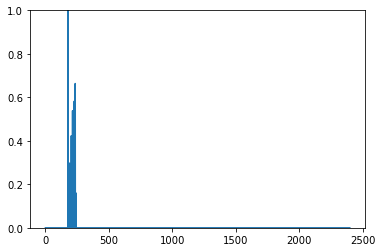

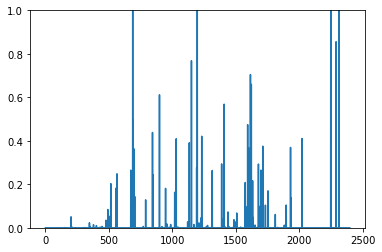

In [69]:
for i in range(len(trigger_list)):
    plt.ylim(0, 1)
    plt.plot(trigger_list[i] * mask_list[i])
    plt.show()